In [1]:
import numpy as np
import matplotlib.pyplot as plt


from include.build_synth import buildData_from_countries as generator

from include.estim.Rt_UnivariateOutliers import Rt_U_O
from include.estim.Rt_Univariate import myRt_U
from include.estim import Rt_Multivariate as RtM
from include.estim import laplacianLearning as LL
from include.estim import Rt_MLE as RtMLE
from include.estim import Rt_L

from importlib import reload
reload(generator), reload(Rt_L)

# np.random.seed(2020)
np.random.seed(1234)

In [2]:
cluster_sizes = [3,3,3]
nclusters = len(cluster_sizes)

firstDay, lastDay = "2020-12-01", "2021-01-10"
# countries = ['France', 'Canada', 'Japan', 'Thailand', 'Austria']
countries = ['France', 'Canada', 'Japan']


if np.sum(cluster_sizes)<=10:
    cmap = "tab10"
    colors = plt.get_cmap(cmap)(np.arange(np.sum(cluster_sizes)))
else:
    cmap = "rainbow"
    colors = plt.get_cmap(cmap)(np.linspace(0.05, 0.95,np.sum(cluster_sizes)))

In [3]:
alpha = 0.1
ZData_by_country, ZData_by_cluster, R_by_cluster, O_by_cluster, options = generator.generate_synthZ(countries, cluster_sizes, firstDay, lastDay, alpha)

Opening data from Johns Hopkins University.
Opening data from Johns Hopkins University.
Opening data from Johns Hopkins University.
Computing Univariate estimation with O misreported counts modelisation ...
Done in 12.8943 seconds ---


First day : 2020-12-01 
 Last day : 2021-01-10


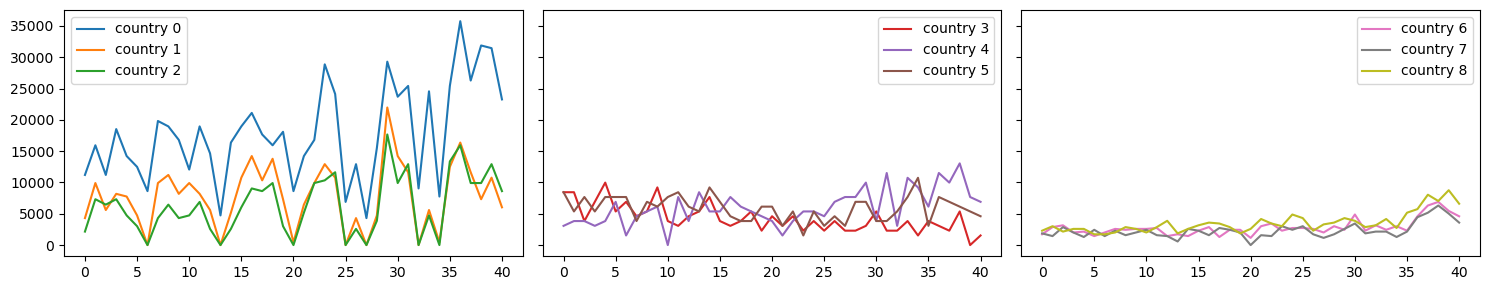

In [4]:
fig, axs = plt.subplots(1,nclusters, figsize=(15,3), sharex=True, sharey="row")
k = 0
for i in range(len(cluster_sizes)):
    for _ in range(cluster_sizes[i]):
        axs[i].plot(ZData_by_country[k], color=colors[k], label="country {}".format(k))
        k+=1
    # axs[i].plot(ZData_by_cluster[i][1:], "k--", label="Original")
    
    axs[i].legend()
plt.tight_layout()
print("First day : {} \n Last day : {}".format(firstDay, lastDay) )

In [5]:
n_max_iter = 8

#init param
init_method = "U"
init_param = {"options":options, "lambdaU_pwlin": 20}

#optim param
lambda_Fro = 0.25
lambda_GR = 1.
lambda_pwlin = 20

Restims, Lestims, _, objs, crits_R, crits_R_true, crits_L, crits_L_true = Rt_L.Rt_L(ZData_by_country, n_max_iter, lambda_pwlin, lambda_GR, lambda_Fro, options, init_method, init_param, save_objective=True)

Computing Univariate estimator ...
Done in 3.1598 seconds ---
lambda_GR = 1.000
Computing Multivariate estimator ...
Done in 8.6315 seconds ---
lambda_GR = 1.000
Computing Multivariate estimator ...
Done in 9.5540 seconds ---
lambda_GR = 1.000
Computing Multivariate estimator ...
Done in 9.6155 seconds ---
lambda_GR = 1.000
Computing Multivariate estimator ...
Done in 9.5698 seconds ---
lambda_GR = 1.000
Computing Multivariate estimator ...
Done in 9.7419 seconds ---
lambda_GR = 1.000
Computing Multivariate estimator ...
Done in 9.5877 seconds ---
lambda_GR = 1.000
Computing Multivariate estimator ...
Done in 9.5509 seconds ---
lambda_GR = 1.000
Computing Multivariate estimator ...
Done in 9.6553 seconds ---


objective function at init : 88.52707085081421


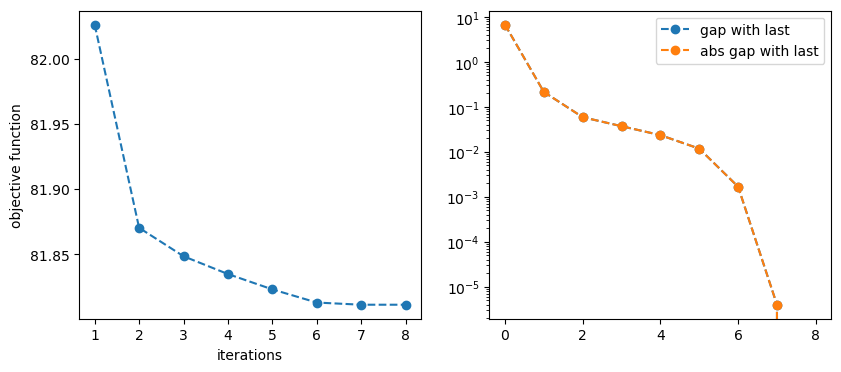

In [6]:
plt.figure(figsize=(15,4))

plt.subplot(131)
print("objective function at init : {}".format(objs[0]))
plt.plot(np.arange(1, n_max_iter+1), objs[1:], '--o')
plt.xlabel("iterations")
plt.ylabel("objective function")

plt.subplot(132)
plt.plot(np.arange(n_max_iter+1), objs-objs[-1], '--o', label="gap with last")
plt.plot(np.arange(n_max_iter+1), np.abs(objs-objs[-1]), '--o', label="abs gap with last")
plt.legend()
plt.yscale("log")

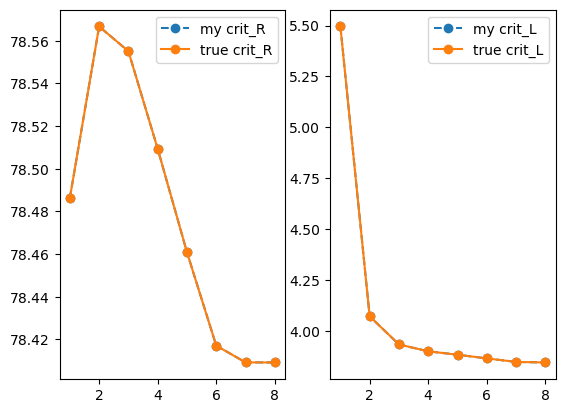

In [7]:
plt.subplot(121)
plt.plot(np.arange(1, n_max_iter+1), crits_R, '--o', label="my crit_R" )
plt.plot(np.arange(1, n_max_iter+1), crits_R_true, '-o', label="true crit_R" )
plt.legend()
plt.subplot(122)
plt.plot(np.arange(1, n_max_iter+1), crits_L, '--o', label="my crit_L" )
plt.plot(np.arange(1, n_max_iter+1), crits_L_true, '-o', label="true crit_L" )
plt.legend()

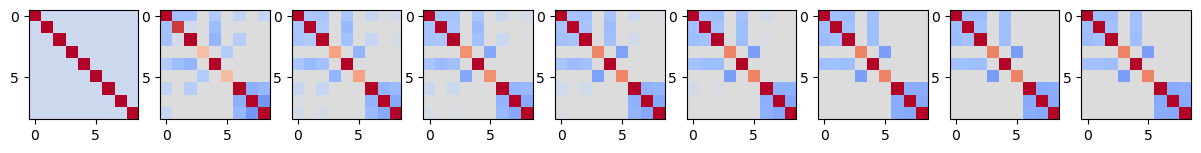

In [8]:
n = Lestims[0].shape[0]
fig, axs = plt.subplots(1, n_max_iter+1, figsize=(15,5), squeeze=False)
for L, ax in zip(Lestims, axs[0]):
    ax.imshow(L, cmap="coolwarm", vmin=-1, vmax=1)
    # for i in range(n):
    #     for j in range(n):
    #         c = L[i,j]
    #         ax.text(i, j, "{:2.1f}".format(c), va='center', ha='center', color="darkgreen")

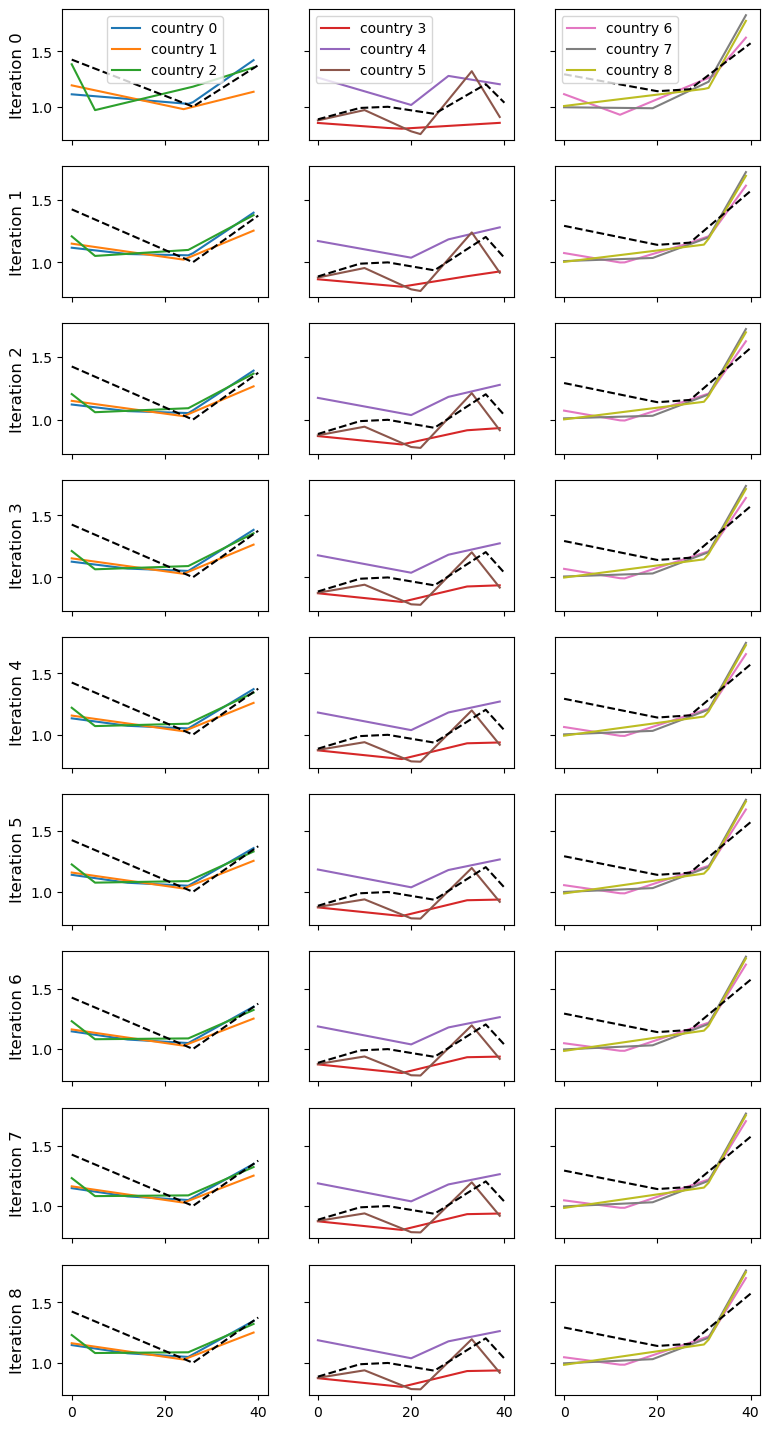

In [9]:
fig, axs = plt.subplots(n_max_iter+1, nclusters, figsize=(3*nclusters,2*(n_max_iter+1)), sharex=True, sharey="row", squeeze=False)
for i in range(n_max_iter+1):
    k = 0
    for j in range(nclusters):
        for _ in range(cluster_sizes[j]):
            axs[i,j].plot(Restims[i][k], color=colors[k], label="country {}".format(k))
            # axs[i,j].plot(Restims[i][k], ':', color=colors[k])
            k+=1
        axs[i,j].plot(R_by_cluster[j], 'k--')
        if i==0:
            axs[i,j].legend()
        if j==0:
            axs[i,j].set_ylabel("Iteration {}".format(i), fontsize=12)
plt.show()